In [ ]:
# data set: https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## bidirectional- LSTM

In [ ]:
! pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 5.0 MB/s 
     |████████████████████████████████| 287 kB 39.7 MB/s 


In [ ]:
# import the packages that needed 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
# from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from rouge import Rouge
import contractions
import re

In [ ]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/cnn_dailymail/train.csv')
# delete the duplicated units in the column of article
df = df.drop(['id'], axis=1)
# only use parts of the training samples
df = df.sample(frac=0.05)
df = df[~df.article.duplicated()]
df.reset_index(drop=True,inplace=True)
df.head(5)

,article,highlights
0,"(CNN) -- To the casual observer, Cristiano Ron...",Cristiano Ronaldo says Real Madrid are under p...
1,Smokers beware - Queensland Health's latest an...,"'If you smoke, your future's not pretty', Quee..."
2,"By . Amanda Williams . PUBLISHED: . 11:36 EST,...",In Scotland temperatures in some areas will di...
3,Watch the full interview with Larry Flynt toni...,"Larry Flynt: ""I've done a great deal to expand..."
4,"By . Rob Cooper . PUBLISHED: . 07:32 EST, 22 O...","Boy stole £2,000 when he held up the Barclays ..."


In [ ]:
def clean_text(text,remove_stopwords=True):
    # the pipeline to clean the text
    # expand the contractions
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words('english'))
        text = [w for w in text if w not in stops]
        text = ' '.join(text)
    return text

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

clean_summaries = []
for summary in df.highlights:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print('-----------Cleaning Summaries Complete-----------')

# clean the text and remove the stopwords
clean_texts = []
for text in df.article:
    clean_texts.append(clean_text(text))
print('-----------Cleaning Texts Complete-----------')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


-----------Cleaning Summaries Complete-----------
-----------Cleaning Texts Complete-----------


In [ ]:
data = {
    'text':clean_texts,
    'highlight':clean_summaries
}
clean_df = pd.DataFrame(data=data)
clean_df.loc[:,'text_length'] = clean_df['text'].apply(lambda x:len(x.split()))
clean_df.loc[:,'highlight_length'] = clean_df['highlight'].apply(lambda x:len(x.split()))

[(0.0, 200.0)]

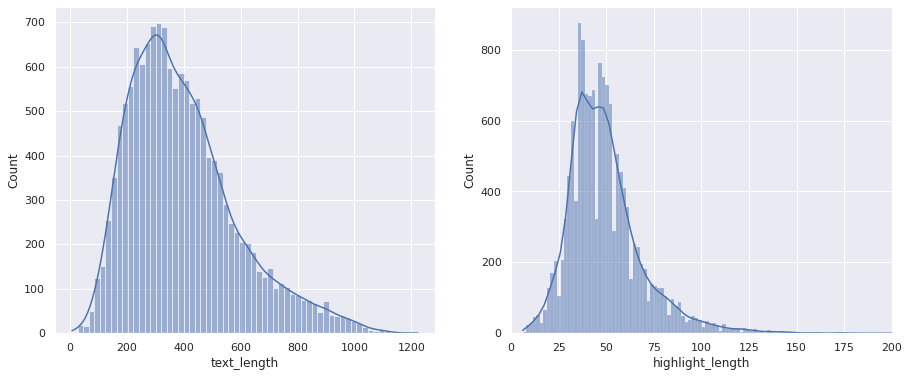

In [ ]:
# visualize the word_length of both the text and the highlight
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
fig,ax = plt.subplots(nrows=1,ncols=2,squeeze=True,figsize=(15,6))
sns.histplot(x='text_length',data=clean_df,ax=ax[0],kde=True)
sns.histplot(x='highlight_length',data=clean_df,ax=ax[1],kde=True).set(xlim=(0,200))

In [ ]:
max_text_len=800
max_summary_len=100

In [ ]:
cnt=0
for i in clean_df['text']:
    if(len(i.split())<=max_text_len):
        cnt=cnt+1
print(cnt/len(clean_df['text']))

0.9549700264882197


In [ ]:
cnt=0
for i in clean_df['highlight']:
    if(len(i.split())<=max_summary_len):
        cnt=cnt+1
print(cnt/len(clean_df['highlight']))

0.9769273665133138


In [ ]:
clean_df = clean_df.where((clean_df['text_length'] < max_text_len) & (clean_df['highlight_length'] < max_summary_len)).reset_index(drop=True)
clean_df.highlight = clean_df.highlight.apply(lambda x : 'sostok '+ str(x) + ' eostok')
clean_df.dropna(how='any',inplace=True)
clean_df.head()

,text,highlight,text_length,highlight_length
0,cnn casual observer cristiano ronaldo look lik...,sostok cristiano ronaldo says real madrid are ...,384.0,59.0
1,smokers beware queensland health latest anti s...,sostok if you smoke your future s not pretty...,338.0,59.0
2,amanda williams published 11 36 est 8 october ...,sostok in scotland temperatures in some areas ...,315.0,35.0
3,watch full interview larry flynt tonight piers...,sostok larry flynt i have done a great deal ...,408.0,38.0
4,rob cooper published 07 32 est 22 october 2013...,sostok boy stole £2 000 when he held up the ba...,515.0,56.0


In [ ]:
# split the data into train and validation group
train_x, val_x, train_y, val_y = train_test_split(clean_df['text'], clean_df['highlight'], test_size=0.1, random_state=123)


In [ ]:
t_tokenizer = Tokenizer()
t_tokenizer.fit_on_texts(list(train_x))
thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in t_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value

    if value < thresh:
        count += 1
        frequency += value
# use the common words, substract rare words from the total vocabulary 
t_max_features = total_count - count
print('Text Vocab: ', t_max_features)

Text Vocab:  46721


In [ ]:
# reassign a tokenizer
maxlen_text = 800
maxlen_sum = 100

t_tokenizer = Tokenizer(num_words=t_max_features)
t_tokenizer.fit_on_texts(list(train_x))
train_x = t_tokenizer.texts_to_sequences(train_x)
train_x = pad_sequences(train_x, maxlen=maxlen_text, padding='post')

In [ ]:
s_tokenizer = Tokenizer()
s_tokenizer.fit_on_texts(list(train_y))

thresh = 6
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in s_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value
s_max_features = total_count-count
s_max_features

8915

In [ ]:
s_tokenizer = Tokenizer(num_words=s_max_features)
s_tokenizer.fit_on_texts(list(train_y))
train_y = s_tokenizer.texts_to_sequences(train_y)
train_y = pad_sequences(train_y, maxlen=maxlen_sum, padding='post')

In [ ]:
# validation dataset
val_x = t_tokenizer.texts_to_sequences(val_x)
val_x = pad_sequences(val_x, maxlen=maxlen_text, padding='post')

val_y = s_tokenizer.texts_to_sequences(val_y)
val_y = pad_sequences(val_y, maxlen=maxlen_sum, padding='post')

In [ ]:
# pretrained embedding from gloves
embedding_index = {}
# first use 100 dimension to test the word embedding result
dim = 100
with open('drive/My Drive/Colab Notebooks/glove.6B/glove.6B.100d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [ ]:
# encodder embedding
t_embed = np.zeros((t_max_features, dim))
for word, i in t_tokenizer.word_index.items():
    vec = embedding_index.get(word)
    if i < t_max_features and vec is not None:
        t_embed[i] = vec

# decoder embedding
s_embed = np.zeros((s_max_features, dim))
for word, i in s_tokenizer.word_index.items():
    vec = embedding_index.get(word)
    if i < s_max_features and vec is not None:
        s_embed[i] = vec

In [ ]:
latent_dim = 128

# Encoder
enc_input = Input(shape=(maxlen_text, ))
enc_embed = Embedding(t_max_features, dim, input_length=maxlen_text, weights=[t_embed], trainable=False)(enc_input)

# h_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# h_out, _, _ = h_lstm(enc_embed)
enc_lstm = Bidirectional(LSTM(latent_dim, return_state=True))
enc_output, enc_fh, enc_fc, enc_bh, enc_bc = enc_lstm(enc_embed)
enc_h = Concatenate(axis=-1, name='enc_h')([enc_fh, enc_bh])
enc_c = Concatenate(axis=-1, name='enc_c')([enc_fc, enc_bc])

#Decoder
dec_input = Input(shape=(None, ))
dec_embed = Embedding(s_max_features, dim, weights=[s_embed], trainable=False)(dec_input)
dec_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
dec_outputs, _, _ = dec_lstm(dec_embed, initial_state=[enc_h, enc_c])

dec_dense = TimeDistributed(Dense(s_max_features, activation='softmax'))
dec_output = dec_dense(dec_outputs)

model = tf.keras.Model([enc_input, dec_input], dec_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 800, 100)     4672100     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 256),        234496      ['embedding[0][0]']              
                                 (None, 128),                                                 

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit([train_x, train_y[:, :-1]], train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:], epochs=10, callbacks=[early_stop], batch_size=128, verbose=2, 
          validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]))

Epoch 1/10
95/95 - 1296s - loss: 3.5788 - val_loss: 3.1137 - 1296s/epoch - 14s/step
Epoch 2/10
95/95 - 1255s - loss: 3.0723 - val_loss: 2.9888 - 1255s/epoch - 13s/step
Epoch 3/10
95/95 - 1245s - loss: 2.9475 - val_loss: 2.8765 - 1245s/epoch - 13s/step
Epoch 4/10
95/95 - 1244s - loss: 2.8559 - val_loss: 2.8117 - 1244s/epoch - 13s/step
Epoch 5/10
95/95 - 1253s - loss: 2.7865 - val_loss: 2.7544 - 1253s/epoch - 13s/step
Epoch 6/10
95/95 - 1251s - loss: 2.7299 - val_loss: 2.7152 - 1251s/epoch - 13s/step
Epoch 7/10
95/95 - 1262s - loss: 2.6827 - val_loss: 2.6829 - 1262s/epoch - 13s/step
Epoch 8/10
95/95 - 1289s - loss: 2.6416 - val_loss: 2.6558 - 1289s/epoch - 14s/step
Epoch 9/10
95/95 - 1332s - loss: 2.6052 - val_loss: 2.6353 - 1332s/epoch - 14s/step
Epoch 10/10
95/95 - 1267s - loss: 2.5721 - val_loss: 2.6146 - 1267s/epoch - 13s/step


In [ ]:
enc_model = tf.keras.Model(inputs=enc_input, outputs=[enc_h, enc_c])

dec_init_state_h = Input(shape=(latent_dim*2, ))
dec_init_state_c = Input(shape=(latent_dim*2, ))

dec_out, dec_h, dec_c = dec_lstm(dec_embed, initial_state=[dec_init_state_h, dec_init_state_c])
dec_final = dec_dense(dec_out)

dec_model = tf.keras.Model([dec_input]+[dec_init_state_h, dec_init_state_c], [dec_final]+[dec_h, dec_c])

In [ ]:
def generate_summary(input_seq):
    h, c = enc_model.predict(input_seq)
    
    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''
    
    stop = False
    count = 0
    
    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c])
        token_idx = np.argmax(decoder_out[0, -1, :])
        
        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token
        
        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1
        
    return output_seq

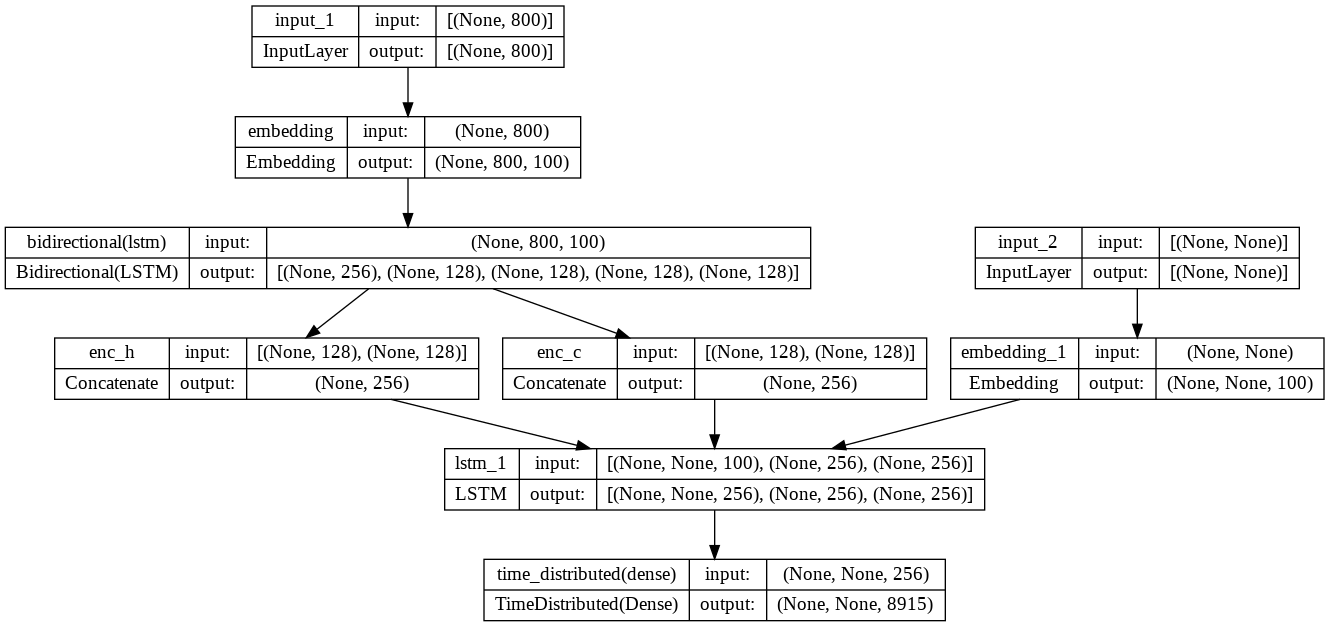

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(
    model,
    to_file='./seq2seq_encoder_decoder.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96)

In [ ]:
# read the test data for predicting and evaluating the model with Rouge

In [ ]:
df_test = pd.read_csv('drive/My Drive/Colab Notebooks/cnn_dailymail/validation.csv')
test_df = df_test.sample(frac=0.1).drop('id',axis=1).reset_index(drop=True)

In [ ]:
test_df.head()

,article,highlights
0,Savers have missed out on £130billion of inter...,Bank of England slashed interest rates to hist...
1,Manager Steve Bruce feels energetic enough to ...,Steve Bruce has signed a new three-year contra...
2,(CNN)Two more American aid workers who had hig...,"After developing symptoms, a worker is moved t..."
3,The BBC has denied claims hackers were respons...,People trying to access the BBC site today wer...
4,Facebook has created a new rule book that tell...,Clarified its policies with a new Community St...


In [ ]:
test_inputs = [clean_text(sent) for sent in test_df.article]
test_inputs = t_tokenizer.texts_to_sequences(list(test_inputs))
test_inputs = pad_sequences(test_inputs, maxlen=maxlen_text, padding='post')

In [ ]:
import csv
hyps = []
with open('drive/My Drive/Colab Notebooks/bi-lstm_result.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Article', 'Original Summary', 'Model Output'])
    for i in range(50):
        our_summ = generate_summary(test_inputs[i].reshape(1, maxlen_text))
        hyps.append(our_summ)
        writer.writerow([test_df.article[i], test_df.highlights[i], our_summ])

In [ ]:
rouge = Rouge()
rouge.get_scores(hyps, test_df.highlights, avg=True, ignore_empty=True)

{'rouge-1': {'r': 0.05350034759153349,
  'p': 0.2689447072535308,
  'f': 0.08629857720682178},
 'rouge-2': {'r': 0.0027660649558725113,
  'p': 0.010965114662785953,
  'f': 0.00431639983850429},
 'rouge-l': {'r': 0.050870687428563065,
  'p': 0.2578793477764066,
  'f': 0.0821909984024637}}